<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/da_mnist_mnistm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Dataset MNIST : Dataloader (used torchvision dataset)
- Datest MNIST-M : Dataloader
- Model 
  - CNN with Classifier
  - CNN with Classifier and Domain Classifier
- Train 
  - Standard Train - Source : MNIST
  - DANN - Source - MNIST, Target - MNIST-M
- Test
  - Standard - MNIST, MNIST-M
  - DANN - MNIST, MNIST-M


In [1]:
!pip install torchinfo 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Import libraries
import numpy as np
import torch # for pytorch functions
from torchvision import datasets # for mnist m dataset
import torchvision.transforms as transforms # transformation with respect to mean, std, 3 channel
%matplotlib inline 
import matplotlib.pyplot as plt # for visualizing images

import random # for random image index
import torch.nn as nn # for network

from tqdm import tqdm # for beautiful model training updates
import torch.optim as optim # for optimizer
import torch.nn.functional as F # functional

import warnings
warnings.filterwarnings("ignore")

In [3]:
#@title Cuda, Seed etc.
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (f' Device : {device}')
# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True
 Device : cuda


In [4]:
#@title MNIST dataset related
## downloading training data, using this to calculate mean and standard deviation 
train_mean_std_dev = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.ToTensor()# converts to tesnor
    )

# Getting Mean and Standard Deviation of dataset MNIST
def get_mean_std_dev(dataset):
  """ Supports only 1 and 3 channel images
  """
  data = dataset.data / 255 # data is numpy array
  
  assert dataset[0][0].shape[0] in [1,3], "Supports only 1 and 3 channel images"

  if dataset[0][0].shape[0]==3:
    mean = tuple(data.mean(axis = (0,1,2))) 
    std = tuple(data.std(axis = (0,1,2)))
  elif dataset[0][0].shape[0]==1:
    mean = tuple([data.mean()])
    std = tuple([data.std()])

  return mean, std

mean, std_dev = get_mean_std_dev(train_mean_std_dev)
print(f"mean : {mean}   std_dev: {std_dev}")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

mean : (tensor(0.1307),)   std_dev: (tensor(0.3081),)


In [5]:
#@title Transforms for MNIST

# Train Phase transformations
train_mnist_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # rotation of 7 degress may help | can be ignored
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(), # converts to tensor
                                       
                                       transforms.Normalize(mean, std_dev) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_mnist_transforms = transforms.Compose([
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(),# converts to tensor
                                       transforms.Normalize(mean, std_dev)
                                       ])


In [6]:
#@title MNIST dataset, train and test split, dataloader
train_mnist = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_mnist_transforms)
test_mnist = datasets.MNIST('./data', 
                      train=False, 
                      download=True, 
                      transform=test_mnist_transforms)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_mnist_loader = torch.utils.data.DataLoader(
    dataset=train_mnist,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_mnist_loader = torch.utils.data.DataLoader(
    dataset = test_mnist,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



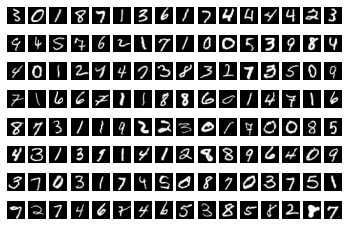

In [7]:
#@title Checking MNIST Dataloader: Looking at images
images, labels  = next(iter(train_mnist_loader))

figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    unscaled_image = ((images[index-1].numpy()*std_dev + mean)*255).astype(np.uint8)
    plt.imshow(np.transpose(unscaled_image, (1, 2, 0)))


In [8]:
#@title MNIST-M dataset related
"""Dataset setting and data loader for MNIST-M.

CREDIT: https://github.com/corenel;https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cogan/mnistm.py
"""

from __future__ import print_function

import errno
import os

import torch
import torch.utils.data as data
from PIL import Image


class MNISTM(data.Dataset):
    """`MNIST-M Dataset."""

    url = "https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz"

    raw_folder = "raw"
    processed_folder = "processed"
    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"

    def __init__(self, root, mnist_root="data", train=True, transform=None, target_transform=None, download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__()
        self.root = os.path.expanduser(root)
        self.mnist_root = os.path.expanduser(mnist_root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found." + " You can use download=True to download it")

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file)
            )
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file)
            )

    def __getitem__(self, index):
        """Get images and target for data loader.

        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and os.path.exists(
            os.path.join(self.root, self.processed_folder, self.test_file)
        )

    def download(self):
        """Download the MNIST data."""
        # import essential packages
        from six.moves import urllib
        import gzip
        import pickle
        from torchvision import datasets

        # check if dataset already exists
        if self._check_exists():
            return

        # make data dirs
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # download pkl files
        print("Downloading " + self.url)
        filename = self.url.rpartition("/")[2]
        file_path = os.path.join(self.root, self.raw_folder, filename)
        if not os.path.exists(file_path.replace(".gz", "")):
            data = urllib.request.urlopen(self.url)
            with open(file_path, "wb") as f:
                f.write(data.read())
            with open(file_path.replace(".gz", ""), "wb") as out_f, gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print("Processing...")

        # load MNIST-M images from pkl file
        with open(file_path.replace(".gz", ""), "rb") as f:
            mnist_m_data = pickle.load(f, encoding="bytes")
        mnist_m_train_data = torch.ByteTensor(mnist_m_data[b"train"])
        mnist_m_test_data = torch.ByteTensor(mnist_m_data[b"test"])

        # get MNIST labels
        mnist_train_labels = datasets.MNIST(root=self.mnist_root, train=True, download=True).train_labels
        mnist_test_labels = datasets.MNIST(root=self.mnist_root, train=False, download=True).test_labels

        # save MNIST-M dataset
        training_set = (mnist_m_train_data, mnist_train_labels)
        test_set = (mnist_m_test_data, mnist_test_labels)
        with open(os.path.join(self.root, self.processed_folder, self.training_file), "wb") as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), "wb") as f:
            torch.save(test_set, f)

        print("Done!")

In [9]:
train_mean_std_dev_mnistm = MNISTM(
                          root = './',# directory where data needs to be stored
                          train = True, # get the training portion of the dataset
                          download = True, # downloads
                          transform = transforms.ToTensor()# converts to tesnor
                          )

Processing...
Done!


In [10]:
len(train_mean_std_dev_mnistm)

60000

In [11]:
# Getting Mean and Standard Deviation of dataset MNISTM
imgs = [item[0] for item in train_mean_std_dev_mnistm]
imgs = torch.stack(imgs, dim=0).numpy()
# calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
mean_mnistm = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
std_dev_mnistm= (std_r,std_g,std_b)

print(f"mean : {mean_mnistm}   std_dev: {std_dev_mnistm}") #mean : (0.46387476, 0.46759155, 0.41990575)   std_dev: (0.25341642, 0.23800454, 0.26179394)

mean : (0.46387476, 0.46759155, 0.41990575)   std_dev: (0.25341642, 0.23800454, 0.26179394)


In [12]:
#@title Transforms for MNISTM

# Train Phase transformations
train_mnistm_transforms = transforms.Compose([
                                      #  transforms.RandomRotation((-7.0, 7.0)), # rotation of 7 degress may help | can be ignored
                                      #  transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(), # converts to tensor
                                       transforms.Normalize(mean_mnistm, std_dev_mnistm) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_mnistm_transforms = transforms.Compose([
                                      #  transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(),# converts to tensor
                                       transforms.Normalize(mean_mnistm, std_dev_mnistm)
                                       ])


In [13]:
#@title MNISTM dataset, train and test split, dataloader
train_mnistm = MNISTM('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_mnistm_transforms)
test_mnistm = MNISTM('./data', 
                      train=False, 
                      download=True, 
                      transform=test_mnistm_transforms)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_mnistm_loader = torch.utils.data.DataLoader(
    dataset=train_mnistm,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_mnistm_loader = torch.utils.data.DataLoader(
    dataset = test_mnistm,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

Processing...
Done!


In [14]:
import math
import itertools

import numpy as np
import matplotlib.pyplot as plt

## Borrowed code, reference unknown

def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.

    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    
    """
    #TODO : Implement for Dataloader
    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)

(<Figure size 576x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

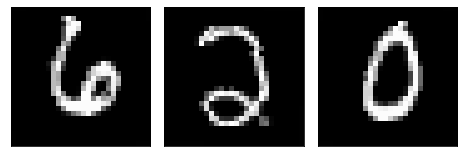

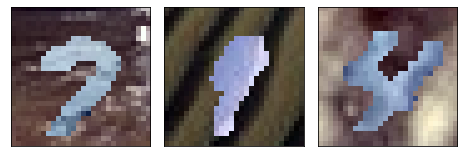

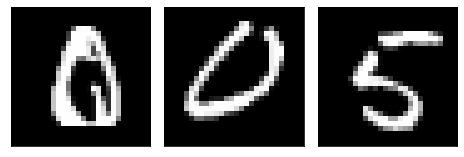

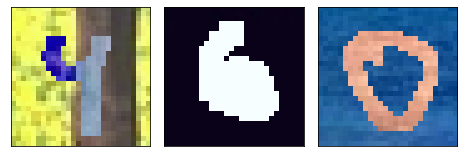

In [15]:
#@title Looking at images of MNIST and MNISTM
## Showing first n images of the dataset
dataset_first_n(train_mnist, 3, cmap='gray')
dataset_first_n(train_mnistm, 3)
dataset_first_n(test_mnist, 3, cmap='gray')
dataset_first_n(test_mnistm, 3)

### Domain Adaptation Model
Model will consist of three parts, as in the figure:

- A "deep" CNN for image feature extraction (2x Conv, ReLU, MaxPool)
- A digit-classification head (3x FC, ReLU)
- A domain classification head (2x FC, ReLU), with **gradient reversal layer** (GRL). GRL is no-op in forward pass, but applies −𝜆 factor to gradient in the backward pass.

In [16]:
#@title GRL Implementation
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, grl_lambda ):
        # Store context for backprop
        ctx.grl_lambda  = grl_lambda 
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -grl_lambda the gradient
        output = grad_output.neg() * ctx.grl_lambda 

        # Must return same number as inputs to forward()
        return output, None

In [17]:
#@title DANN Model
drop = 0.1
class DACNN(nn.Module):
    def __init__(self,drop = drop):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5), # input - 3x28x28, output - 64x24x24
            nn.BatchNorm2d(64), 
            nn.MaxPool2d(2), # input - 64x24x24, output - 64x12x12
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5), # input - 64x12x12, output - 50x8x8
            nn.BatchNorm2d(50), 
            nn.Dropout(drop), 
            nn.MaxPool2d(2),# input - 50x8x8, output - 50x4x4
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), # FC1
            nn.BatchNorm1d(100), 
            nn.Dropout(drop),
            nn.ReLU(True),
            nn.Linear(100, 100), # FC2
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),# FC3
            # nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),  # FC1
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),# FC2
            # nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        # x = x.expand(x.data.shape[0], 3, 28, 28)
        
        features = self.feature_extractor(x)
        # print("features.shape: ",features.shape)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return F.log_softmax(class_pred, dim=1), F.log_softmax(domain_pred, dim=1)

In [18]:

from torchinfo import summary
model = DACNN().to(device)
batch_size = 2
summary(model, input_size=(batch_size, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DACNN                                    [2, 10]                   --
├─Sequential: 1-1                        [2, 50, 4, 4]             --
│    └─Conv2d: 2-1                       [2, 64, 24, 24]           4,864
│    └─BatchNorm2d: 2-2                  [2, 64, 24, 24]           128
│    └─MaxPool2d: 2-3                    [2, 64, 12, 12]           --
│    └─ReLU: 2-4                         [2, 64, 12, 12]           --
│    └─Conv2d: 2-5                       [2, 50, 8, 8]             80,050
│    └─BatchNorm2d: 2-6                  [2, 50, 8, 8]             100
│    └─Dropout: 2-7                      [2, 50, 8, 8]             --
│    └─MaxPool2d: 2-8                    [2, 50, 4, 4]             --
│    └─ReLU: 2-9                         [2, 50, 4, 4]             --
├─Sequential: 1-2                        [2, 10]                   --
│    └─Linear: 2-10                      [2, 100]                  80,100
│ 

In [19]:
source = 'mnist'
target = 'mnistm'

if source == 'mnist' and target == 'mnistm': # SOURCE : MNIST, TARGET: MNISTM
  dl_source_train = train_mnist_loader
  dl_source_val = test_mnist_loader
  dl_target_train = train_mnistm_loader
  dl_target_val = test_mnistm_loader
else: # SOURCE : MNISTM, TARGET: MNIST
  dl_source_train = train_mnistm_loader
  dl_source_val = test_mnistm_loader
  dl_target_train = train_mnist_loader
  dl_target_val = test_mnist_loader

In [20]:
#@title Checking if the model, dataloader etc. are working by sending data to untrained model
x0_s, y0_s = next(iter(dl_source_train))
x0_t, y0_t = next(iter(dl_target_train))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

model(x0_s.to(device)), model(x0_t.to(device))

source domain:  torch.Size([128, 3, 28, 28]) torch.Size([128])
target domain:  torch.Size([128, 3, 28, 28]) torch.Size([128])


((tensor([[-2.5370, -2.4878, -2.2213,  ..., -2.2149, -2.3285, -2.2288],
          [-2.3700, -2.6267, -3.0543,  ..., -2.4885, -2.3161, -1.9970],
          [-1.8682, -2.5476, -2.9347,  ..., -2.4195, -2.1483, -2.1588],
          ...,
          [-2.5488, -2.0150, -1.7231,  ..., -2.4145, -2.4028, -2.6998],
          [-2.5274, -2.2779, -2.2817,  ..., -2.2958, -2.4158, -2.1054],
          [-2.1740, -2.4231, -2.8949,  ..., -1.8669, -2.3844, -2.9367]],
         device='cuda:0', grad_fn=<LogSoftmaxBackward0>),
  tensor([[-0.5331, -0.8838],
          [-0.8736, -0.5403],
          [-0.8738, -0.5402],
          [-0.8988, -0.5226],
          [-0.9464, -0.4913],
          [-1.2272, -0.3469],
          [-0.7555, -0.6345],
          [-0.5288, -0.8899],
          [-0.7157, -0.6711],
          [-0.5677, -0.8366],
          [-0.9055, -0.5181],
          [-1.1911, -0.3622],
          [-0.8043, -0.5932],
          [-0.7201, -0.6669],
          [-0.1997, -1.7091],
          [-0.5252, -0.8951],
          [-0.

let $\lambda$ (`grl_lambda` in the code) change during training (e.g. every epoch)

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradulaly changed from 0 to 1 in the course of training.
    $$
    \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

In [21]:
#@title Typical training function

def train(model, device, train_loader, criterion, scheduler, optimizer):
    """Function to train the model
    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        train_loader (instance): Torch Dataloader instance for trainingset
        criterion (instance): criterion to used for calculating the loss
        scheduler (function): scheduler to be used
        optimizer (function): optimizer to be used
    Returns:
        float: accuracy and loss values
    """
    model.train()
    pbar = tqdm(train_loader)
    lr_trend = []
    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
        # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
        # ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred,_ = model(data) # we are interested in only class prediction
        # Calculate loss
        loss = criterion(y_pred, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        # updating LR
        if scheduler:
            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
                lr_trend.append(scheduler.get_last_lr()[0])

        train_loss += loss.item()

        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # Update pbar-tqdm
        pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/(batch_idx + 1):.5f} Accuracy={100*correct/processed:0.2f}%')
    
    return 100*correct/processed, train_loss/(batch_idx + 1), lr_trend

In [22]:
#@title Typical test function
def test(model, device, test_loader, criterion):
    """put model in eval mode and test it
    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        test_loader (instance): Torch Dataloader instance for testset
        criterion (instance): criterion to used for calculating the loss
    Returns:
        float: accuracy and loss values
    """
    model.eval()
    test_loss = 0
    correct = 0
    #iteration = len(test_loader.dataset)// test_loader.batch_size
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data) # we are interested in only class prediction
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset), test_loss

In [23]:
def save_model(model, epoch, optimizer, path):
    """Save torch model in .pt format
    Args:
        model (instace): torch instance of model to be saved
        epoch (int): epoch num
        optimizer (instance): torch optimizer
        path (str): model saving path
    """
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, path)

In [24]:
def fit_model(net, optimizer, criterion, device, NUM_EPOCHS,train_loader, test_loader, scheduler=None, save_best=False):
    """Fit the model
    Args:
        net (instance): torch model instance of defined model
        optimizer (function): optimizer to be used
        criterion (instance): criterion to used for calculating the loss
        device (str): "cpu" or "cuda" device to be used
        NUM_EPOCHS (int): number of epochs for model to be trained
        train_loader (instance): Torch Dataloader instance for trainingset
        test_loader (instance): Torch Dataloader instance for testset
        scheduler (function, optional): scheduler to be used. Defaults to None.
        save_best (bool, optional): If save best model to model.pt file, paramater validation loss will be monitered
    Returns:
        (model, list): trained model and training logs
    """
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
    lr_trend = []
    if save_best:
        min_val_loss = np.inf
        save_path = 'model.pt'

    for epoch in range(1,NUM_EPOCHS+1):
        print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))
        
        train_acc, train_loss, lr_hist = train(
            model=net, 
            device=device, 
            train_loader=train_loader, 
            criterion=criterion ,
            optimizer=optimizer, 
            scheduler=scheduler
        )
        test_acc, test_loss = test(net, device, test_loader, criterion)
        # update LR
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
        
        if save_best:
            if test_loss < min_val_loss:
                print(f'Valid loss reduced from {min_val_loss:.5f} to {test_loss:.6f}. checkpoint created at...{save_path}\n')
                save_model(net, epoch, optimizer, save_path)
                min_val_loss = test_loss
            else:
                print(f'Valid loss did not improve from {min_val_loss:.5f}\n')
        else:
            print()

        training_acc.append(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        lr_trend.extend(lr_hist)    

    if scheduler:   
        return net, (training_acc, training_loss, testing_acc, testing_loss, lr_trend)
    else:
        return net, (training_acc, training_loss, testing_acc, testing_loss)

In [25]:
#@title Model fit for Typical Model (Non-DANN)

lr = 1e-3
n_epochs = 5

# Setup optimizer as usual 
typical_model = DACNN() 

optimizer = optim.Adam(typical_model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

# # We'll train the same number of batches from both datasets
# max_batches = min(len(dl_source_train), len(dl_target_train))
# print(len(dl_source_train), len(dl_target_train), max_batches)

typical_model, tuple_acc_loss = fit_model(net = typical_model.to(device), 
                                          optimizer = optimizer, 
                                          criterion = loss_fn_class, 
                                          device = device, 
                                          NUM_EPOCHS = n_epochs,
                                          train_loader = dl_source_train, 
                                          test_loader=dl_source_val, 
                                          scheduler=None, 
                                          save_best=True)

EPOCH: 1 (LR: 0.001)


Batch_id=468 Loss=0.16694 Accuracy=96.51%: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]



Test set: Average loss: 0.0399, Accuracy: 9881/10000 (98.81%)
Valid loss reduced from inf to 0.039912. checkpoint created at...model.pt

EPOCH: 2 (LR: 0.001)


Batch_id=468 Loss=0.05002 Accuracy=98.49%: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]



Test set: Average loss: 0.0287, Accuracy: 9908/10000 (99.08%)
Valid loss reduced from 0.03991 to 0.028738. checkpoint created at...model.pt

EPOCH: 3 (LR: 0.001)


Batch_id=468 Loss=0.03519 Accuracy=98.97%: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]



Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)
Valid loss reduced from 0.02874 to 0.025720. checkpoint created at...model.pt

EPOCH: 4 (LR: 0.001)


Batch_id=468 Loss=0.02944 Accuracy=99.09%: 100%|██████████| 469/469 [00:28<00:00, 16.30it/s]



Test set: Average loss: 0.0269, Accuracy: 9914/10000 (99.14%)
Valid loss did not improve from 0.02572

EPOCH: 5 (LR: 0.001)


Batch_id=468 Loss=0.02757 Accuracy=99.13%: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s]



Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)
Valid loss reduced from 0.02572 to 0.025495. checkpoint created at...model.pt



In [26]:
#@title DANN training function

def dann_train_model(model, 
                     device, 
                     train_source_loader, 
                     train_target_loader, 
                     optimizer,  
                     epoch, 
                     num_epochs =5,
                     loss_fn_class = F.nll_loss, 
                     loss_fn_domain = F.nll_loss):
    """Function to train the model
    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        train_source_loader (instance): Torch Dataloader instance for source training set
        train_target_loader (instance): Torch Dataloader instance for target training set
        optimizer (function): optimizer to be used
        epoch (int) : the current epoch the model is trained for
        num_epochs (int): number of epochs for model to be trained
        loss_fn_class (instance): criterion to used for calculating the label loss
        loss_fn_domain (instance) : criterion to used for calculating the domain loss
        
    Returns:
        float: accuracy and class loss values
    """
    model.train() # setting the model in training mode
    correct = 0
    processed = 0
    train_loss = 0

    # understanding batch size by understanding length of two dataloaders
    len_dataloader = min(len(train_source_loader), len(train_target_loader)) # training for minimum of two dataloaders
    
    i = 0 # as the training progresses the alpha changes
    while i < len_dataloader -1:
        # implementation of alpha as per paper
        p = float(i + epoch * len_dataloader) / (num_epochs * len_dataloader)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(iter(train_source_loader))
        X_s, y_s = X_s.to(device), y_s.to(device)
        batch_size = X_s.shape[0]
        y_s_domain = torch.zeros(batch_size, dtype=torch.long).to(device) # generate source domain labels, source domain is zero

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        train_loss += loss_s_label.item()
        pred = class_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(y_s.view_as(pred)).sum().item()
        processed += batch_size

        # Train on target domain
        X_t, _ = next(iter(train_target_loader)) # ignore target domain class labels!
        X_t = X_t.to(device)
        batch_size = X_t.shape[0]
        y_t_domain = torch.ones(batch_size, dtype=torch.long).to(device) # generate target domain labels, target domain is zero

        _, domain_pred = model(X_t, grl_lambda) # ignore the model output in terms of class labels
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()

        if ((i + 1) % 100 == 0):
          print(f'[{i+1}/{len_dataloader}] '
                f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
                f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
              )
        
        i = i+1
    return 100*correct/processed, train_loss/i


In [27]:

def fit_model_dann(net, 
                   optimizer, 
                   device, 
                   NUM_EPOCHS, 
                   train_source_loader,
                   train_target_loader, 
                   test_source_loader, 
                   loss_fn_class = F.nll_loss, 
                   loss_fn_domain = F.nll_loss,
                   save_best=False):
    """Fit the model
    Args:
        net (instance): torch model instance of defined model
        optimizer (function): optimizer to be used
        device (str): "cpu" or "cuda" device to be used
        NUM_EPOCHS (int): number of epochs for model to be trained
        train_loader (instance): Torch Dataloader instance for trainingset
        train_source_loader (instance): Torch Dataloader instance for source training set
        train_target_loader (instance): Torch Dataloader instance for target training set
        test_source_loader (instance): Torch Dataloader instance for source testset
        save_best (bool, optional): If save best model to model.pt file, paramater validation loss will be monitered
    Returns:
        (model, list): trained model and training logs
    """
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
    if save_best:
        min_val_loss = np.inf
        save_path = 'dann_model.pt'

    for epoch in range(1,NUM_EPOCHS+1):
        print(f'EPOCH: {epoch}')
        
        train_acc, train_loss = dann_train_model(model = net, 
                                                device = device, 
                                                train_source_loader = train_source_loader, 
                                                train_target_loader = train_target_loader, 
                                                optimizer = optimizer,  
                                                epoch =epoch, 
                                                num_epochs =NUM_EPOCHS,
                                                loss_fn_class = loss_fn_class, 
                                                loss_fn_domain = loss_fn_domain)
        
        test_acc, test_loss = test(net, device, test_loader = test_source_loader, criterion= loss_fn_class)

        
        if save_best:
            if test_loss < min_val_loss:
                print(f'Valid loss reduced from {min_val_loss:.5f} to {test_loss:.6f}. checkpoint created at...{save_path}\n')
                save_model(net, epoch, optimizer, save_path)
                min_val_loss = test_loss
            else:
                print(f'Valid loss did not improve from {min_val_loss:.5f}\n')
        else:
            print()

        training_acc.append(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)

    return net, (training_acc, training_loss, testing_acc, testing_loss)

In [28]:
#@title Model fit for DANN Model 

lr = 1e-3
n_epochs = 5

# Setup optimizer as usual 
dann_model = DACNN() 

optimizer = optim.Adam(dann_model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()


dann_model, tuple_acc_loss =fit_model_dann(net = dann_model.to(device), 
                                          optimizer = optimizer, 
                                          device = device, 
                                          NUM_EPOCHS = n_epochs,
                                          train_source_loader = dl_source_train,
                                          train_target_loader = dl_target_train, 
                                          test_source_loader = dl_source_val, 
                                          loss_fn_class = loss_fn_class, 
                                          loss_fn_domain =loss_fn_domain,
                                          save_best=True)

EPOCH: 1
[100/469] class_loss: 0.3672 s_domain_loss: 0.3673 t_domain_loss: 1.1952 grl_lambda: 0.837 
[200/469] class_loss: 0.6951 s_domain_loss: 0.3386 t_domain_loss: 1.3411 grl_lambda: 0.890 
[300/469] class_loss: 0.5513 s_domain_loss: 0.4382 t_domain_loss: 0.9140 grl_lambda: 0.927 
[400/469] class_loss: 0.4293 s_domain_loss: 1.0334 t_domain_loss: 0.4006 grl_lambda: 0.952 

Test set: Average loss: 0.2314, Accuracy: 9536/10000 (95.36%)
Valid loss reduced from inf to 0.231382. checkpoint created at...dann_model.pt

EPOCH: 2
[100/469] class_loss: 0.1027 s_domain_loss: 0.8219 t_domain_loss: 0.4925 grl_lambda: 0.976 
[200/469] class_loss: 0.1679 s_domain_loss: 0.6998 t_domain_loss: 0.5200 grl_lambda: 0.984 
[300/469] class_loss: 0.4236 s_domain_loss: 0.5715 t_domain_loss: 0.6372 grl_lambda: 0.990 
[400/469] class_loss: 0.2928 s_domain_loss: 0.5326 t_domain_loss: 0.8463 grl_lambda: 0.993 

Test set: Average loss: 0.2317, Accuracy: 9441/10000 (94.41%)
Valid loss did not improve from 0.23138


In [29]:
#@title Confusion Metrics, Accuracy, Precision, Recall, F1
classes = ('0','1','2','3','4','5','6','7','8','9')

dict_testloader = {"Source Val": dl_source_val,"Target Val":dl_target_val}
dict_model = {"Typical": typical_model,"DANN": dann_model}


------------Model = Typical, Domain Validation = Source Val---------
confusion matrix 
      0     1     2     3    4    5    6     7    8    9
0  975     0     0     0    0    0    2     1    2    0
1    0  1132     1     0    0    2    0     0    0    0
2    1     0  1021     1    1    0    0     8    0    0
3    0     1     1  1005    0    2    0     0    1    0
4    0     0     0     0  979    0    1     0    0    2
5    0     0     0     6    0  882    2     1    0    1
6    2     3     0     0    1    2  948     0    2    0
7    0     2     1     0    0    0    0  1024    1    0
8    2     1     0     1    0    0    0     0  968    2
9    1     2     0     0   12    2    0     6    1  985
 Accuracy = 0.9919 
Precision = [0.99388379 0.99211218 0.99707031 0.99210267 0.98590131 0.99101124
 0.99475341 0.98461538 0.99282051 0.99494949] 
 Recall = [0.99489796 0.99735683 0.98934109 0.9950495  0.99694501 0.98878924
 0.98956159 0.99610895 0.99383984 0.97621407] 
f1 = [0.99439062 0.9947275

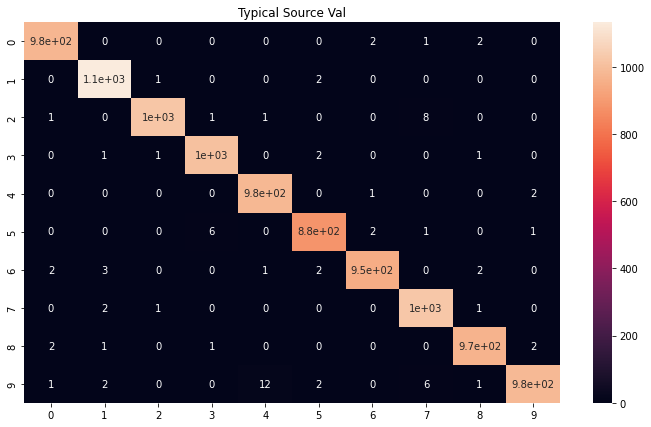

------------Model = Typical, Domain Validation = Target Val---------
confusion matrix 
      0     1    2    3    4    5    6    7    8    9
0  482   300   55   18    8   37   54   17    6    3
1   22  1019   23    4   13   20    9   23    2    0
2   26   418  488   11   12   20    8   28   10   11
3   69   343   39  435    6   83   13    8   12    2
4   15   418   35   18  401   45    9   36    4    1
5   18   258   10   19    3  552   14    5   12    1
6   53   353   13    6   16  125  385    2    5    0
7   12   408   29    5   10   14    2  535   12    1
8   28   440   62   64   10   92   28   45  197    8
9   36   425   50   26   69   57    2  139    9  196
 Accuracy = 0.469 
Precision = [0.63337714 0.23254222 0.60696517 0.71782178 0.73175182 0.52822967
 0.73473282 0.63842482 0.73234201 0.87892377] 
 Recall = [0.49183673 0.89779736 0.47286822 0.43069307 0.40835031 0.61883408
 0.40187891 0.52042802 0.20225873 0.19425173] 
f1 = [0.55370477 0.36940366 0.53159041 0.53836634 0.52418301

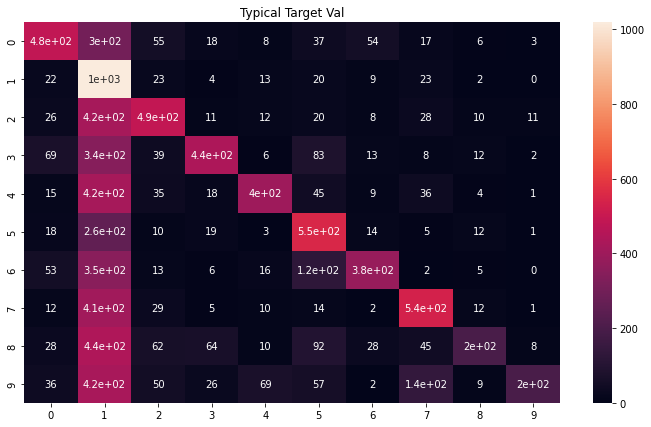

------------Model = DANN, Domain Validation = Source Val---------
confusion matrix 
      0     1    2    3    4    5    6    7    8    9
0  758     0    6   17    2   11  115    3   59    9
1    0  1062    0   31    6    7    3    1   12   13
2    1    15  653  175   13    3    7   55   89   21
3    0     0    0  950    0    4    0    1    6   49
4    0     1    0    0  862    1   14    0    0  104
5    0     9    0  190    2  546   13    0   67   65
6    2     4    0    0   27    5  917    0    3    0
7    4     3   16  107    7    4    0  442   13  432
8    2     4    0   25    8    1    5    4  796  129
9    3     2    0   13   15    2    2    0    2  970
 Accuracy = 0.7956 
Precision = [0.98441558 0.96545455 0.96740741 0.62997347 0.91507431 0.93493151
 0.85223048 0.87351779 0.76026743 0.54129464] 
 Recall = [0.77346939 0.93568282 0.63275194 0.94059406 0.87780041 0.61210762
 0.95720251 0.42996109 0.81724846 0.96134787] 
f1 = [0.86628571 0.95033557 0.76508494 0.75456712 0.8960499  0

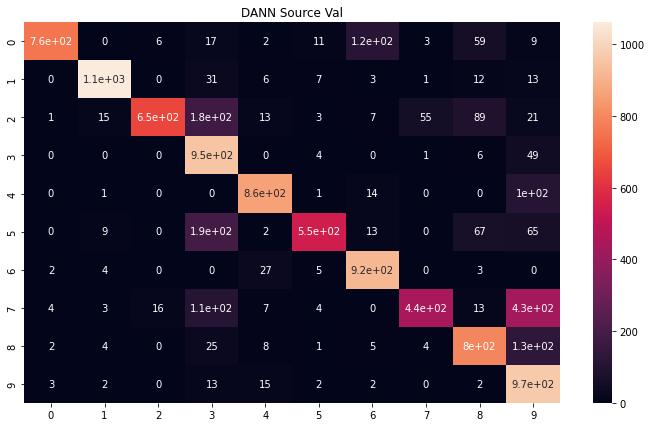

------------Model = DANN, Domain Validation = Target Val---------
confusion matrix 
      0    1   2    3   4    5    6    7    8    9
0  231   40   9   41   8   36  101  262  172   80
1   61  324  23   94  15    5  140  282  166   25
2   27  140  56  134  19   26  106  289  161   74
3   20  104  10  239  13   26   69  290  130  109
4   18  119  18   37  84   32  106  268  165  135
5   23   73  12   41  13  186   80  221  143  100
6   36   99   4   14  25   78  355  160  161   26
7   31   68  28   77  14   15   55  471  155  114
8   56  110   7   34   7   33  101  270  262   94
9   22   68  10   48  12   10   48  341  147  303
 Accuracy = 0.2511 
Precision = [0.44       0.28296943 0.31638418 0.31488801 0.4        0.41610738
 0.30577089 0.16503153 0.1576414  0.28584906] 
 Recall = [0.23571429 0.28546256 0.05426357 0.23663366 0.08553971 0.20852018
 0.37056367 0.45817121 0.26899384 0.30029732] 
f1 = [0.30697674 0.28421053 0.09263854 0.27020916 0.1409396  0.27781927
 0.33506371 0.24265842 

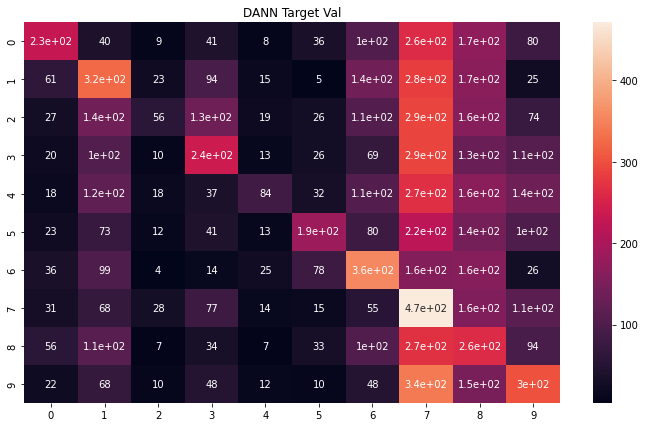

In [31]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,f1_score,accuracy_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


for model_name, model in dict_model.items():
  model.eval()  # setting the model into evaluation mode
  grl_lambda = 0
  for domain_name, test_loader  in dict_testloader.items():
    y_pred = []
    y_true = []

    for (X_t,y_t) in test_loader:
      X_t, y_t = X_t.to(device), y_t.long().to(device) #sending data to CPU or GPU as per device

      # Ground Truth Values
      truths = y_t.tolist()
      # truths = y_t.cpu().numpy() # CPU
      y_true.extend(truths) # Save Truth

      # Prediction Values
      class_outputs, _  = model(X_t, grl_lambda = grl_lambda) # forward pass, plural results
      preds = (torch.max(torch.exp(class_outputs), 1)[1]).tolist()

      # print(preds)
      # preds = class_outputs.argmax(dim=1, keepdim=True).data.cpu().numpy()  # CPU
      y_pred.extend(preds) # Save Predicted
      
    # Build confusion matrix
    print(f'------------Model = {model_name}, Domain Validation = {domain_name}---------')
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score (y_true, y_pred, average=None)
    f1 = f1_score (y_true, y_pred, average=None)

    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                         columns = [i for i in classes])
    print("confusion matrix \n",df_cm)
    print (f' Accuracy = {accuracy} \nPrecision = {precision} \n Recall = {recall} \nf1 = {f1}')
    plt.figure(figsize = (12,7))
    ax = plt.axes()
    sn.heatmap(df_cm, ax= ax, annot=True)

    ax.set_title(model_name+" "+domain_name)
    plt.show()
    # sn.heatmap(df_cm, annot=True)